<a href="https://colab.research.google.com/github/Obs25/Brain-Tumor-MRI-Image-Classification/blob/master/Brain_tumour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


# Dataset Path

In [ ]:

data_dir = '/content/drive/MyDrive/Tumour/train'
classes = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
print("Tumor Classes Found:", classes)


Tumor Classes Found: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


### 1. Understanding the dataset

Count Images in Each Class

glioma: 564 images
meningioma: 358 images
no_tumor: 335 images
pituitary: 438 images


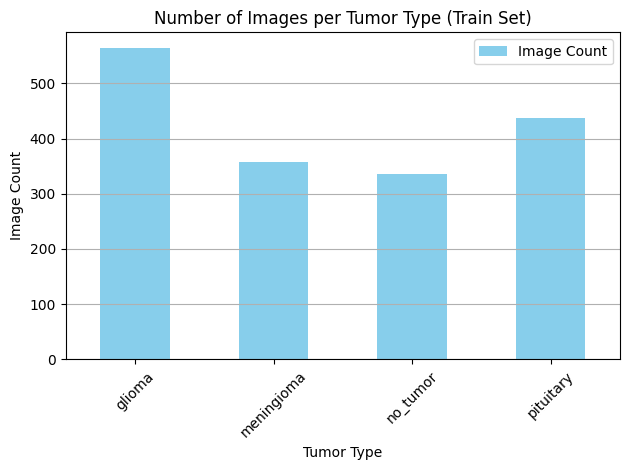

In [ ]:
image_counts = {}

for cls in classes:
    folder_path = os.path.join(data_dir, cls)
    count = len(os.listdir(folder_path))
    image_counts[cls] = count
    print(f"{cls}: {count} images")

# Visualizing the distribution
df = pd.DataFrame(list(image_counts.items()), columns=['Tumor Type', 'Image Count'])
df.plot(kind='bar', x='Tumor Type', y='Image Count', color='skyblue')
plt.title("Number of Images per Tumor Type (Train Set)")
plt.xlabel("Tumor Type")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Show One Sample Image Per Class

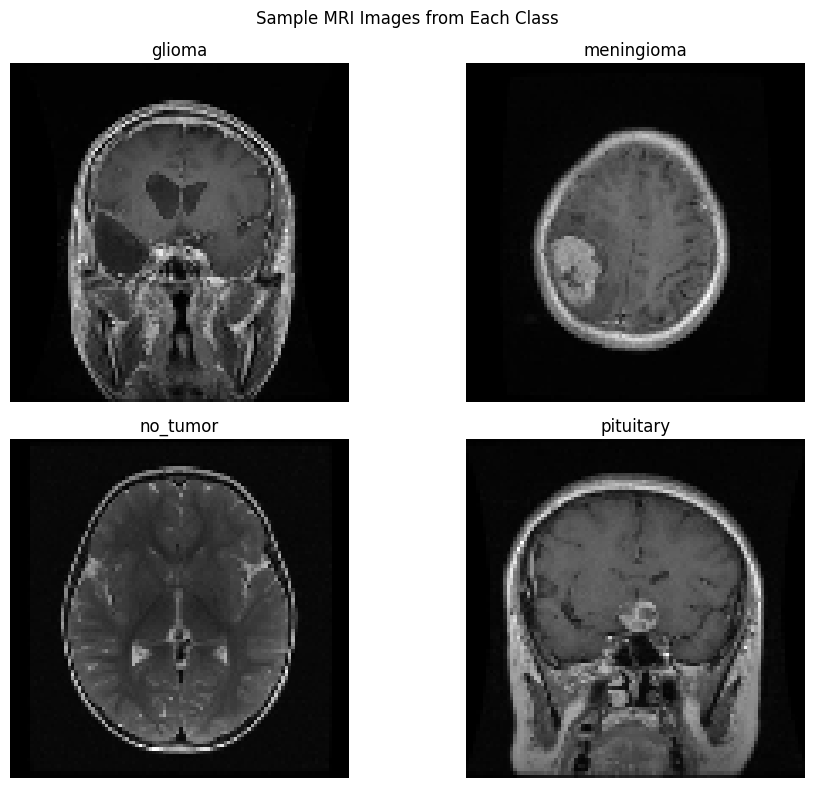

In [ ]:
img_size = 100

plt.figure(figsize=(10, 8))

for i, cls in enumerate(classes):
    folder_path = os.path.join(data_dir, cls)
    img_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))

    plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample MRI Images from Each Class")
plt.tight_layout()
plt.show()


Check Image Resolution Consistency

In [ ]:
shapes = []

for cls in classes:
    folder_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(folder_path)[:10]:  # Just check 10 per class
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        shapes.append(img.shape)

unique_shapes = set(shapes)
print("Unique image resolutions found in the dataset:", unique_shapes)


Unique image resolutions found in the dataset: {(640, 640)}


# Data Preprocessing

Set Preprocessing Configuration

In [ ]:

image_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)


Create Data Generators

In [ ]:
train_path = '/content/drive/MyDrive/Tumour/train'
valid_path = '/content/drive/MyDrive/Tumour/valid'
test_path  = '/content/drive/MyDrive/Tumour/test'

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# Data Augmentation

Define Augmented Train Generator

In [ ]:
train_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Validation and test should NOT be augmented
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)


Load Images with Augmentation Applied to Train

In [ ]:
# Image size and batch size
image_size = 224
batch_size = 32

train_path = '/content/drive/MyDrive/Tumour/train'
valid_path = '/content/drive/MyDrive/Tumour/valid'
test_path  = '/content/drive/MyDrive/Tumour/test'

# Use augmented train generator
train_data = train_augmented.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

# Use normal generator for validation and test
valid_data = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


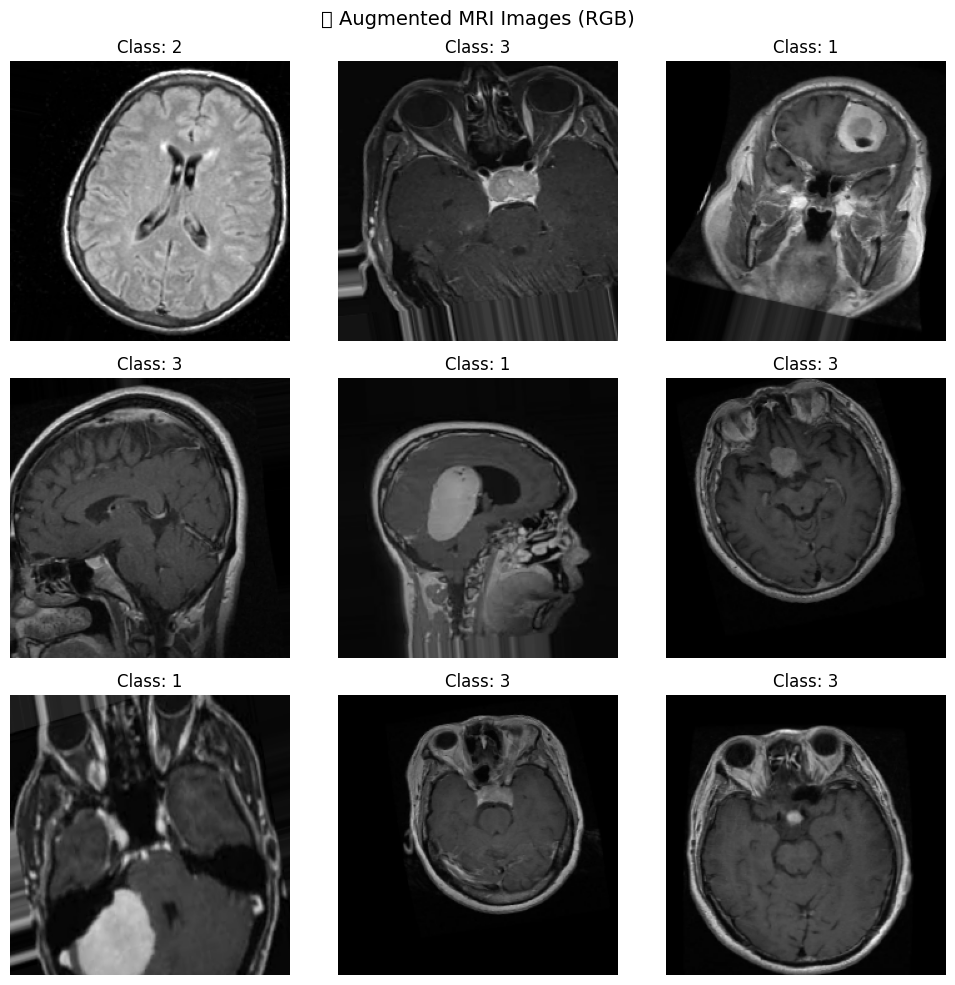

In [ ]:
x_batch, y_batch = next(train_data)

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])  # No reshape needed for RGB
    plt.title(f"Class: {np.argmax(y_batch[i])}")
    plt.axis('off')

plt.suptitle("🔁 Augmented MRI Images (RGB)", fontsize=14)
plt.tight_layout()
plt.show()


# Model Building (Custom CNN)

CNN Model

In [ ]:

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer (4 classes)
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary (optional)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

# Transfer Learning

Load Pretrained Base Model

In [ ]:
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(image_size, image_size, 3))


base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 tumor classes


model_tl = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model_tl.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_tl.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Fine-Tuning (Unfreeze Top Layers)

In [ ]:
# Unfreeze last 20 layers of base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile again (required after changing .trainable)
model_tl.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])


# Set Up Model Saving Paths

In [ ]:
# Saving the best model for custom CNN
cnn_checkpoint = ModelCheckpoint('best_custom_cnn.h5', monitor='val_loss',
                                  save_best_only=True, verbose=1)

# Saving the model for transfer learning
tl_checkpoint = ModelCheckpoint('best_transfer_model.h5', monitor='val_loss',
                                 save_best_only=True, verbose=1)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Training Custom CNN

In [ ]:
history_cnn = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop, cnn_checkpoint]
)


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.4594 - loss: 2.3305
Epoch 1: val_loss improved from inf to 6.21553, saving model to best_custom_cnn.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.4600 - loss: 2.3168 - val_accuracy: 0.2351 - val_loss: 6.2155
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.5100 - loss: 1.1318
Epoch 2: val_loss did not improve from 6.21553
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 685ms/step - accuracy: 0.5098 - loss: 1.1316 - val_accuracy: 0.2351 - val_loss: 12.2469
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.5344 - loss: 1.0671
Epoch 3: val_loss did not improve from 6.21553
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 649ms/step - accuracy: 0.5343 - loss: 1.0674 - val_accuracy: 0.2351 - val_loss: 14.9282
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.5308 - loss: 1.0917
Epoch 4: val_loss did not improve from 6.21553
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 654ms/step - accuracy: 0.5313 - loss: 1.0912 - val_accuracy: 0.2351 - val_loss: 17.9336


Training Transfer Learning Model

In [ ]:
history_tl = model_tl.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop, tl_checkpoint]
)


Epoch 1/15
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.2754 - loss: 1.6881
Epoch 1: val_loss improved from inf to 1.44274, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 933ms/step - accuracy: 0.2780 - loss: 1.6818 - val_accuracy: 0.4203 - val_loss: 1.4427
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.5294 - loss: 1.1622
Epoch 2: val_loss improved from 1.44274 to 1.26547, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - accuracy: 0.5296 - loss: 1.1611 - val_accuracy: 0.4622 - val_loss: 1.2655
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6770 - loss: 0.8810
Epoch 3: val_loss improved from 1.26547 to 1.21953, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 647ms/step - accuracy: 0.6767 - loss: 0.8809 - val_accuracy: 0.4482 - val_loss: 1.2195
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7174 - loss: 0.7808
Epoch 4: val_loss improved from 1.21953 to 1.18474, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 683ms/step - accuracy: 0.7175 - loss: 0.7805 - val_accuracy: 0.4821 - val_loss: 1.1847
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7489 - loss: 0.7063
Epoch 5: val_loss improved from 1.18474 to 1.13999, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 633ms/step - accuracy: 0.7489 - loss: 0.7059 - val_accuracy: 0.5319 - val_loss: 1.1400
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.7572 - loss: 0.6210
Epoch 6: val_loss improved from 1.13999 to 1.12137, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 661ms/step - accuracy: 0.7573 - loss: 0.6211 - val_accuracy: 0.5458 - val_loss: 1.1214
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7794 - loss: 0.5876
Epoch 7: val_loss improved from 1.12137 to 1.08054, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 631ms/step - accuracy: 0.7796 - loss: 0.5872 - val_accuracy: 0.5757 - val_loss: 1.0805
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.7870 - loss: 0.5539
Epoch 8: val_loss improved from 1.08054 to 1.03385, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 695ms/step - accuracy: 0.7873 - loss: 0.5533 - val_accuracy: 0.5976 - val_loss: 1.0339
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8052 - loss: 0.5350
Epoch 9: val_loss improved from 1.03385 to 0.97564, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 630ms/step - accuracy: 0.8054 - loss: 0.5345 - val_accuracy: 0.6235 - val_loss: 0.9756
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8222 - loss: 0.4985
Epoch 10: val_loss improved from 0.97564 to 0.92768, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 660ms/step - accuracy: 0.8222 - loss: 0.4983 - val_accuracy: 0.6514 - val_loss: 0.9277
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8265 - loss: 0.4392
Epoch 11: val_loss improved from 0.92768 to 0.86996, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 650ms/step - accuracy: 0.8264 - loss: 0.4396 - val_accuracy: 0.6713 - val_loss: 0.8700
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.8489 - loss: 0.4356
Epoch 12: val_loss improved from 0.86996 to 0.82438, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 651ms/step - accuracy: 0.8488 - loss: 0.4360 - val_accuracy: 0.6853 - val_loss: 0.8244
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8539 - loss: 0.4262
Epoch 13: val_loss improved from 0.82438 to 0.76964, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 639ms/step - accuracy: 0.8538 - loss: 0.4260 - val_accuracy: 0.7112 - val_loss: 0.7696
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8593 - loss: 0.3985
Epoch 14: val_loss improved from 0.76964 to 0.75422, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 652ms/step - accuracy: 0.8592 - loss: 0.3985 - val_accuracy: 0.7151 - val_loss: 0.7542
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8636 - loss: 0.3799
Epoch 15: val_loss improved from 0.75422 to 0.73815, saving model to best_transfer_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 631ms/step - accuracy: 0.8637 - loss: 0.3798 - val_accuracy: 0.7151 - val_loss: 0.7381


In [ ]:
def plot_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Custom CNN

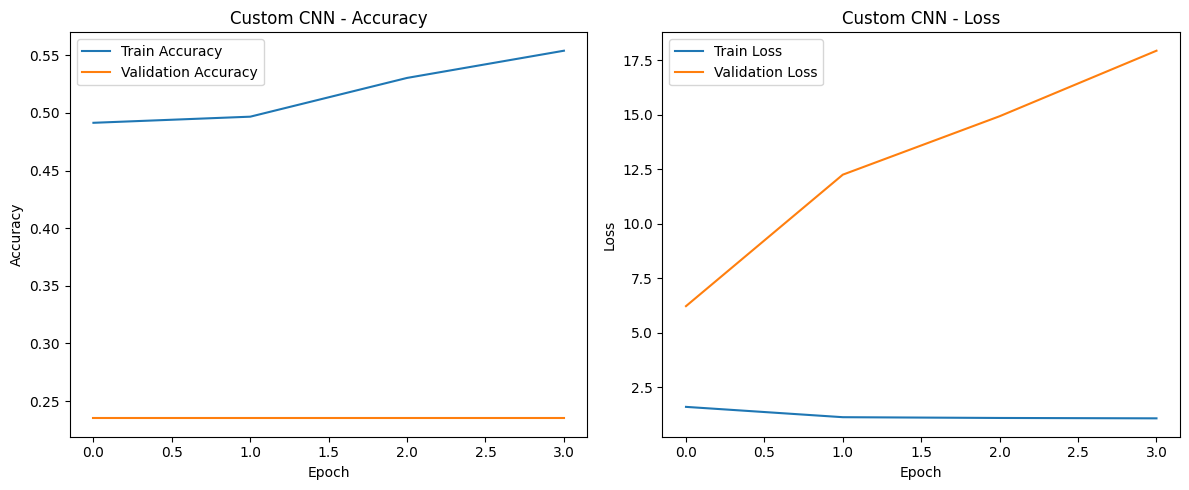

In [ ]:
plot_history(history_cnn, "Custom CNN")


MobileNEt

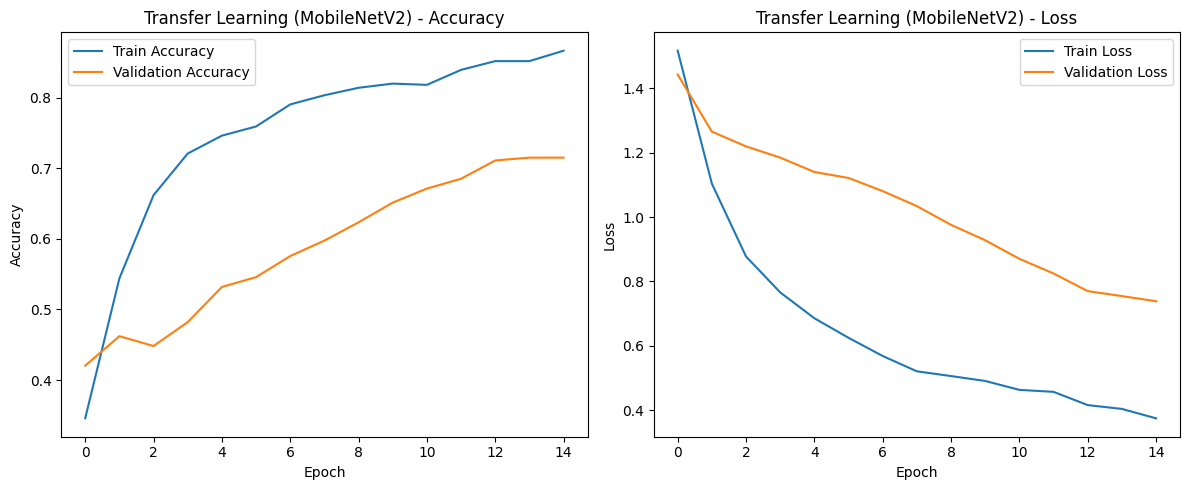

In [ ]:
plot_history(history_tl, "Transfer Learning (MobileNetV2)")


# Evaluate Model on Test Data

For Custom CNN

In [ ]:
cnn_loss, cnn_acc = model.evaluate(test_data)
print(f"Custom CNN - Test Accuracy: {cnn_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 102s 15s/step - accuracy: 0.0647 - loss: 5.6330
Custom CNN - Test Accuracy: 0.22


 For Transfer Learning

In [ ]:
tl_loss, tl_acc = model_tl.evaluate(test_data)
print(f"Transfer Model - Test Accuracy: {tl_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7697 - loss: 0.6328
Transfer Model - Test Accuracy: 0.71


# Classification Report + Confusion Matrix


In [ ]:

y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())


y_pred_cnn = model.predict(test_data)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_pred_tl = model_tl.predict(test_data)
y_pred_tl_classes = np.argmax(y_pred_tl, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 653ms/step


Classification Report (Precision, Recall, F1)

In [ ]:
print("=== Custom CNN ===")
print(classification_report(y_true, y_pred_cnn_classes, target_names=class_labels))

print("\n=== Transfer Learning ===")
print(classification_report(y_true, y_pred_tl_classes, target_names=class_labels))


=== Custom CNN ===
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.22      1.00      0.36        54

    accuracy                           0.22       246
   macro avg       0.05      0.25      0.09       246
weighted avg       0.05      0.22      0.08       246


=== Transfer Learning ===
              precision    recall  f1-score   support

      glioma       0.60      1.00      0.75        80
  meningioma       1.00      0.21      0.34        63
    no_tumor       0.97      0.59      0.73        49
   pituitary       0.75      0.96      0.85        54

    accuracy                           0.71       246
   macro avg       0.83      0.69      0.67       246
weighted avg       0.81      0.71      0.66       246



Confusion Matrix Plot Function

In [ ]:
def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


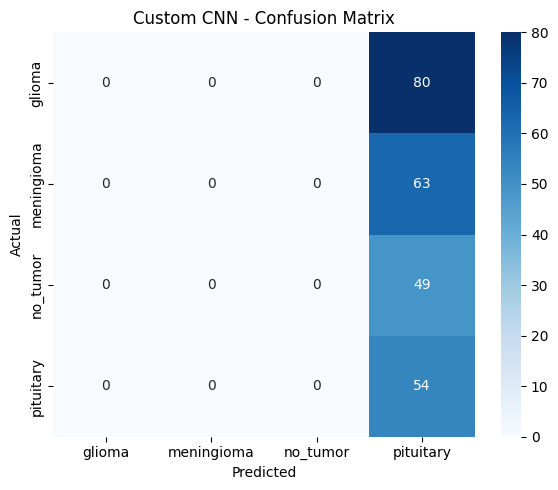

In [ ]:
plot_conf_matrix(y_true, y_pred_cnn_classes, class_labels, "Custom CNN - Confusion Matrix")


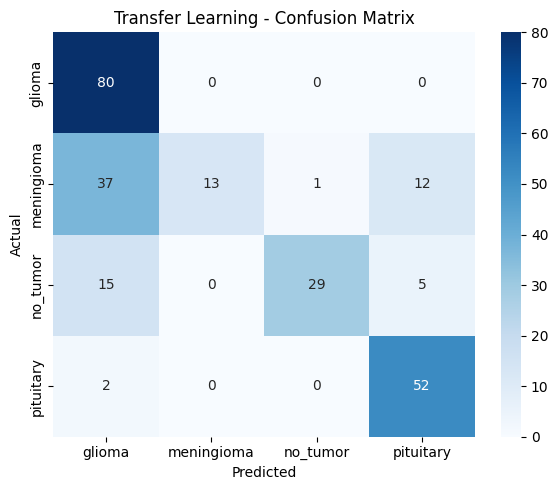

In [ ]:
plot_conf_matrix(y_true, y_pred_tl_classes, class_labels, "Transfer Learning - Confusion Matrix")


# Model Comparison

In [ ]:
print("Model Accuracy Comparison")
print(f"Custom CNN Accuracy        : {cnn_acc:.4f}")
print(f"Transfer Learning Accuracy : {tl_acc:.4f}")


Model Accuracy Comparison
Custom CNN Accuracy        : 0.2195
Transfer Learning Accuracy : 0.7073


In [ ]:

report_tl = classification_report(y_true, y_pred_tl_classes, target_names=class_labels, output_dict=True)
f1_tl = report_tl['weighted avg']['f1-score']

report_cnn = classification_report(y_true, y_pred_cnn_classes, target_names=class_labels, output_dict=True)
f1_cnn = report_cnn['weighted avg']['f1-score']

print(f"Weighted F1 Score (CNN)  : {f1_cnn:.4f}")
print(f"Weighted F1 Score (TL)   : {f1_tl:.4f}")


Weighted F1 Score (CNN)  : 0.0790
Weighted F1 Score (TL)   : 0.6626


In [ ]:
# Save the trained model
model_tl.save("brain_tumor_model.h5")
